# 선형회귀 실습 - 공유자전거 대여 수요 예측

캐글의 자전거 대여 수요 데이터셋을 활용하여 선형회귀 예측모델을 만드는 과정을 실습해보겠습니다. 데이터세트는 https://www.kaggle.com/c/bike-sharing-demand/data에서 내려받을 수 있습니다. train.csv 파일만 다운받아서 노트북 폴더에 복사해 둡니다.

![](https://imgdb.in/k7rr.jpg)

위 데이터세트는 2011년 1월부터 2012년 12월까지 2년동안 매일 1시간 간격으로 자전거 대여 횟수를 기록한 자료입니다. 데이터세트의 칼럼은 아래와 같습니다.

- datetime : 날짜 + 시각(1시간 간격)
- season : 계절(봄여름가을겨울 순으로 1, 2, 3, 4)
- holiday : 휴일이면 1, 휴일이 아니면 0(주말은 0)
- workingday : 주중이면 1, 주말이나 휴일이면 0
- weather : 날씨(1-맑거나 약간 구름, 2-안개, 3-가벼운 눈이나 비, 4-심한 눈이나 천둥번개)
- temp : 온도(섭씨)
- atemp : 체감온도(섭씨)
- humidity : 상대습도
- windspeed : 풍속(단위?)
- casual : 미등록 사용자(비회원) 대여횟수
- registered : 등록회원 대여횟수
- count : 대여횟수(예측대상)

본격적으로 예측작업을 하기 전에 데이터 탐색을 한 번 해 봅시다.

In [197]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.read_csv("./train.csv")
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


10886개의 행과 12개의 칼럼으로 구성되어 있네요. 다행히 Null 데이터도 없고요.

0번 행인 datetime을 보면 자료형이 "object"입니다. "연-월-일 시:분:초" 형식의 문자열로 구성되어 있는데, [연, 월, 일, 시] 네 개의 칼럼으로 분리하도록 하겠습니다. (분과 초는 0이므로 무시합시다.)

In [199]:
# 연월일시 추출방법 1(datetime 메서드 활용)
df["datetime"] = df.datetime.apply(pd.to_datetime)  # 파이썬에서 제공하는 datetime 인스턴스로 변경
df["year"] = df.datetime.apply(lambda x: x.year)
df["month"] = df.datetime.apply(lambda x: x.month)
df["day"] = df.datetime.apply(lambda x: x.day)
df["hour"] = df.datetime.apply(lambda x: x.hour)

df.drop(["datetime"], inplace=True, axis=1)  # datetime 열 제거
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [200]:
# 위의 연월일시 변환 코드를 이해하기 위한 예시

import datetime as dt

sample = "2011-01-01 00:00:00"
print(dt.datetime.strptime(sample, "%Y-%m-%d %H:%M:%S"))

2011-01-01 00:00:00


또 한 가지, casual과 registered는 합하면 count가 됩니다. 즉, 상관도가 높아 예측을 저해할 우려가 있어서 깔끔하게 지워버려도 되지만, 욱하는 마음에 자전거를 타는 사람 비율이 예측에 도움이 될까 싶기도 한데요. 한 번 상관관계를 알아볼까요?

In [201]:
df["ratio"] = df["casual"] / df["registered"]
df["ratio"].describe()

count    1.088600e+04
mean              inf
std               NaN
min      0.000000e+00
25%      6.574394e-02
50%      1.692308e-01
75%      3.394495e-01
max               inf
Name: ratio, dtype: float64

<AxesSubplot:xlabel='ratio', ylabel='count'>

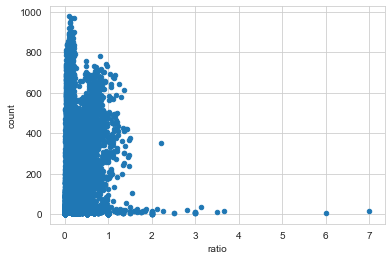

In [202]:
df.plot.scatter("ratio", "count")

In [203]:
df[["casual", "registered", "ratio", "count"]].corr()

,casual,registered,ratio,count
casual,1.000000,0.497250,0.505726,0.690414
registered,0.497250,1.000000,-0.052397,0.970948
ratio,0.505726,-0.052397,1.000000,0.095852
count,0.690414,0.970948,0.095852,1.000000


ratio와 count의 상관관계는 0에 아주 가까운, 아무 짝에도 쓸모없는 관계를 갖고 있군요. 다시 지우겠습니다.

In [204]:
df.drop(["ratio"], inplace=True, axis=1)

이참에 아예 모든 칼럼별로 어떤 값에 count가 많이 들어가는지 시각화해보는 건 어떨까요?
(주의: 시간이 상당히 걸림)

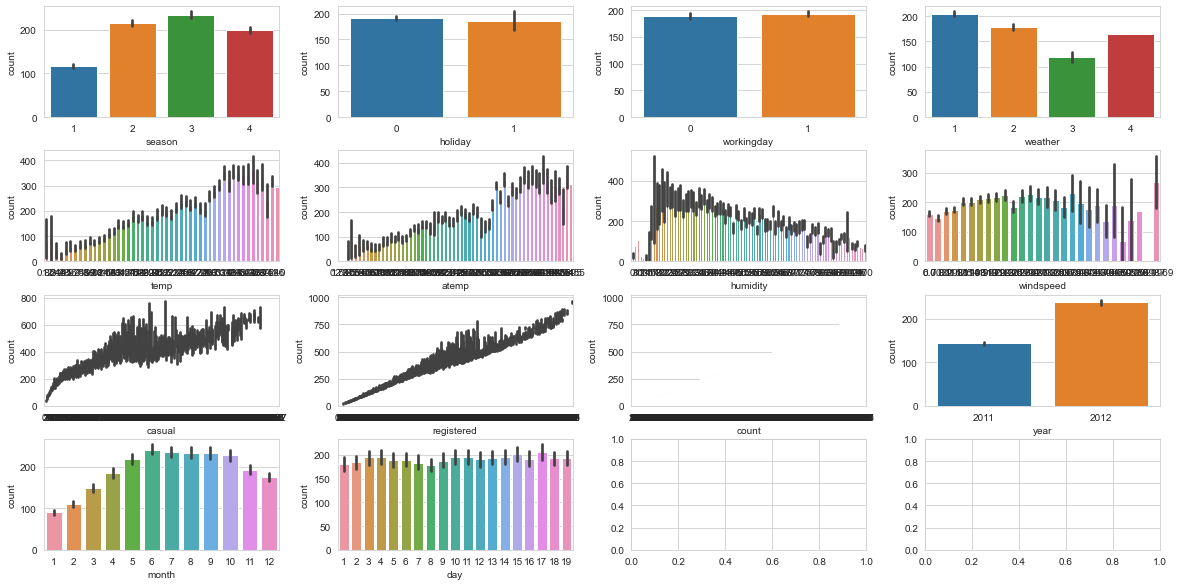

In [205]:
fig, ax = plt.subplots(figsize=(20, 10), ncols=4, nrows=4)
cat_features = df.columns.tolist()[:-1]
for idx, feature in enumerate(cat_features):
    row = int(idx // 4)
    col = idx % 4
    sns.barplot(x=feature, y="count", data=df, ax=ax[row][col])
fig.subplots_adjust(wspace=0.25, hspace=0.3)

In [206]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

X_features = df.drop(["count"], axis=1, inplace=False)
y_target = df["count"]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3)

In [207]:
lr = LinearRegression()
lr.fit(X_train, y_train)
predict = lr.predict(X_test)
print(rmse(y_test, predict))

2.7937860897074635e-13


이상하리만큼 오차가 0에 가깝네요...?
이럴 땐 의심을 해봐야 합니다.


In [208]:
# 실제 대여값과 예측 대여값의 차이가 많이 나는 순서대로 출력
result_df = pd.DataFrame(y_test.values, columns=['real_count'])
result_df['predicted_count']= np.round(predict)
result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

result_df.sort_values('diff', ascending=False)[:20]

,real_count,predicted_count,diff
0,159,159.0,0.0
2181,84,84.0,0.0
2171,30,30.0,0.0
2172,121,121.0,0.0
2173,139,139.0,0.0
2174,137,137.0,0.0
2175,238,238.0,0.0
2176,63,63.0,0.0
2177,126,126.0,0.0
2178,8,8.0,0.0


이건 뭐 완전히 동일한 값이 나와버리네요? 왜 그럴까요?
앞에서 언급했지만, casual + registered = count이기 때문입니다.
선형회귀로 학습한 가중치를 한 번 확인해보겠습니다.

In [209]:
lr.coef_

array([ 2.35072898e-14,  4.72948333e-13, -1.11492442e-14,  3.04806161e-14,
       -3.39321394e-15,  1.56572037e-15, -2.11610727e-15,  5.18715886e-16,
        1.00000000e+00,  1.00000000e+00, -1.52550771e-15, -3.83997754e-15,
       -2.35569733e-16,  7.88869862e-16])

8번과 9번 칼럼만 가중치가 1로 학습되고, 나머지 특성들은 모두 0으로 수렴하였습니다..
간단히 생각해보면 casual과 registered는 나중에 집계한 숫자일 뿐, 예측에는 활용될 수 없는 값이기 때문에
이 두 개의 특성은 (겸허히) 제거한 후에 예측모델을 다시 만드는 게 좋겠습니다.
동일하게 선형회귀 모델을 학습해보겠습니다.

In [210]:
X_features = df.drop(["casual", "registered", "count"], axis=1, inplace=False)
y_target = df["count"]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3)

lr = LinearRegression()
lr.fit(X_train, y_train)
predict = lr.predict(X_test)
print(rmse(y_test, predict))

143.76496415957087


모르긴 몰라도 144라는 (엄청나게 큰) 숫자가 튀어나왔습니다ㄷㄷ
어느 정도 오차인지 잘 감이 오지 않으니 실제값과 예측값의 차이를 다시 한 번 확인해보겠습니다.

In [211]:
result_df = pd.DataFrame(y_test.values, columns=['real_count'])
result_df['predicted_count']= np.round(predict)
result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

result_df.sort_values('diff', ascending=False)[:20]

,real_count,predicted_count,diff
2466,834,191.0,643.0
718,839,204.0,635.0
3061,809,198.0,611.0
1885,784,183.0,601.0
1494,917,342.0,575.0
756,968,405.0,563.0
1028,884,328.0,556.0
1810,797,245.0,552.0
1116,856,314.0,542.0
779,758,216.0,542.0


<AxesSubplot:xlabel='real_count', ylabel='predicted_count'>

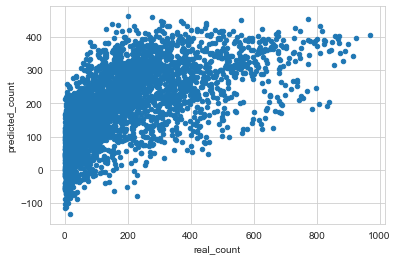

In [212]:
result_df.plot.scatter("real_count", "predicted_count")

개판이네요.. "834대"를 빌려간 날의 예측값이 "190대"이니 못써먹겠네요.
그래도 어떻게든 잘 보완해서 성능을 끌어올려봐야 하지 않겠습니까?

회귀에서 이렇게 큰 오류가 발생하는 경우 가장 먼저 확인해야 할 것은 "타겟 값의 분포"입니다. 타겟값이 미려한 정규분포곡선을 띠고 있으면 제일 좋은데, 이런 경우는 정말 흔하지 않죠.

<AxesSubplot:>

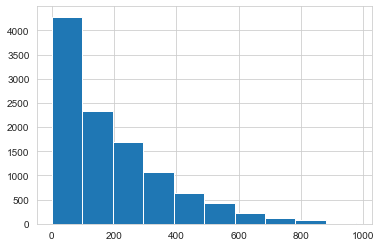

In [213]:
y_target.hist()

이런 히스토그램이라면, 로그변환을 한 번 해보면 정규분포 형태를 띠기도 합니다.

<AxesSubplot:>

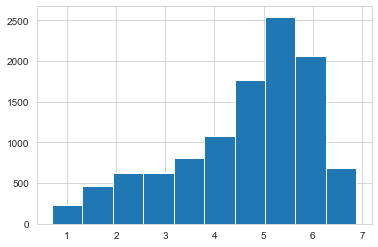

In [214]:
y_log = np.log1p(y_target)
y_log.hist()

(반대쪽으로 쏠려버린 느낌이 없잖아 있지만...)
변환하기 전보다는 훨씬 나은 모양이네요.
이걸로 다시 학습한 후 평가해보겠습니다.
마지막엔 로그로 변환했던 값을 exp로 복원해야 하는 과정 꼭 잊지 마세요!

In [215]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3)
lr = LinearRegression()
lr.fit(X_train, y_train)
predict = lr.predict(X_test)

y_test = np.expm1(y_test)  # 원래 스케일로 변환(복원)
predict = np.expm1(predict)  # 로그변환된 타겟값을 기반으로 예측했으므로 예측값도 스케일 복원

rmse(y_test, predict)

159.84501972536475

점입가경이네요.. RMSE가 더 커졌습니다ㅜㅜㅜ
뭐가 문제인지 가중치를 다시 점검해봅시다..

<AxesSubplot:>

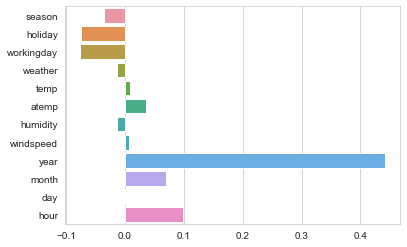

In [216]:
coef = pd.Series(lr.coef_, index=X_features.columns)
sns.barplot(x=coef.values, y=coef.index)

이건 뭐죠? 가장 영향이 큰 가중치(계수)가 year 특성이네요? 2011, 2012가 가장 영향도가 높다고...?
...라고 생각하실 수 있지만 이게 말이 되는 게, 아래 그래프를 보시면 이해가 될 겁니다.

<AxesSubplot:xlabel='year', ylabel='count'>

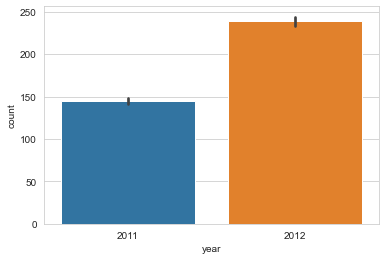

In [217]:
sns.barplot(x="year", y="count", data=df)

2012년에는 자전거 대여횟수가 훅 늘었어요. 두 배 가까이 늘었네요.
그래서 우리 모델도 2012년이면 대여횟수가 크고, 2011년에는 대여횟수가 적다고 해석한 거겠죠.
> 광고를 많이 해서인지, 점차 대중화가 되고 있어서인지.. 알게 뭐람ㅜ

# 이쯤에서 우리가 간과하고 있던..
(미리 눈치채신 분도 많겠지만)
## 아주 중요한 사실 한 가지를 알려드리겠습니다.

우리 선형회귀 모델은 12(월)을 1(월)보다 중요하게 생각하는 경향이 있어요.
31(일)을 01(일)보다 30배 크다고 인식하고, 겨울이 봄보다 네 배 정도 크다고 여겨요.
연월일시나 계절을 카테고리처럼 인식하는 게 아니라 크기비교가 가능한 숫자라고 인식해버리기 때문에
숫자로 된 값에 영향을 크게 받아요.
그래서 이들을 모두 카테고리형 특성으로 변환해줘야 해요.
가장 많이 사용하는 기법인 "원-핫 인코딩"을 적용해보겠습니다.
판다스에서 제공하는 get_dummies를 사용하겠습니다.

In [218]:
# X_features = pd.get_dummies(X_features, columns=["year", "month", "day", "hour", "holiday", "workingday", "season", "weather"])
X_features.info()  # 특성이 72개로 훅 늘어납니다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   year        10886 non-null  int64  
 9   month       10886 non-null  int64  
 10  day         10886 non-null  int64  
 11  hour        10886 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1020.7 KB


In [219]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3)
lr = LinearRegression()
lr.fit(X_train, y_train)
predict = lr.predict(X_test)

y_test = np.expm1(y_test)  # 원래 스케일로 변환(복원)
predict = np.expm1(predict)  # 로그변환된 타겟값을 기반으로 예측했으므로 예측값도 스케일 복원

rmse(y_test, predict)

162.1581605258671

오, 뭔가 숫자가 두자리 아래로 내려가니까 성능이 (엄청) 좋아진 것 같네요!
다시 영향력이 큰 계수를 알아볼까요?

<AxesSubplot:>

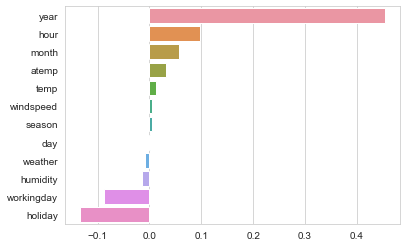

In [220]:
coef = pd.Series(lr.coef_, index=X_features.columns).sort_values(ascending=False)[:20]
sns.barplot(x=coef.values, y=coef.index)

year가 올킬하던 예전과는 달리, 계절과 월, 일도 높은 영향도를 보이고 있습니다.
위에서 실행했던, 예측값과 실제값의 차이를 다시 알아보겠습니다.

In [221]:
result_df = pd.DataFrame(y_test.values, columns=['real_count'])
result_df['predicted_count']= np.round(predict)
result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

result_df.sort_values('diff', ascending=False)[:20]

,real_count,predicted_count,diff
1906,148.0,909.0,761.0
468,201.0,961.0,760.0
1157,839.0,85.0,754.0
760,758.0,89.0,669.0
1015,110.0,777.0,667.0
3233,750.0,95.0,655.0
93,721.0,73.0,648.0
314,710.0,65.0,645.0
3132,759.0,116.0,643.0
2504,276.0,914.0,638.0


여전히 개판인 건 부인할 수 없지만, 그리드서치나 다항회귀를 해도 크게 성능이 향상될 것 같지는 않습니다.

아쉽지만 마지막으로 사이킷런에서 제공하는 앙상블모델 중 랜덤포레스트, 그래디언트 부스팅 모델과
외부 라이브러리인 XG부스트, 마이크로소프트에서 제작한 lightgbm 등
성능이 뛰어나다는 회귀(트리)모델을 전부 가져와서 학습을 돌려보겠습니다.

In [222]:
!pip install xgboost lightgbm

In [243]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


def get_diff():
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(predict)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    print(result_df.sort_values('diff', ascending=False)[:20])


rf = RandomForestRegressor(n_estimators=500)
gbm = GradientBoostingRegressor(n_estimators=500)
xgb = XGBRegressor(n_estimators=500)
lgbm = LGBMRegressor(n_estimators=500)

for model in [rf, gbm, xgb, lgbm]:
    # get_model_predict(model, X_train, X_test, y_train, y_test)
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3)
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    y_test = np.expm1(y_test)  # 원래 스케일로 변환(복원)
    predict = np.expm1(predict)  # 로그변환된 타겟값을 기반으로 예측했으므로 예측값도 스케일 복원
    print(model)
    print(rmse(y_test, predict))
    # get_diff()



RandomForestRegressor(n_estimators=500)
47.105349277271564
GradientBoostingRegressor(n_estimators=500)
46.42909634705627
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
44.231857582598565
LGBMRegressor(n_estimators=500)
41.721985955837525


회귀 트리 모델들은 대체로 40 부근의 준수한 RMSE 값을 보입니다.
회귀 트리가 항상 선형회귀보다 뛰어난 성능을 보이는 모델은 아닙니다.
데이터세트의 유형에 따라 얼마든지 결과가 달라질 수 있습니다.
그래도 이번 자전거 대여 예측 모델에는 선형회귀보다 트리모델이 더 적합한 것으로 보입니다.

이번에는 이 모델 중 하나를 골라 예측값을 리턴해주는 함수를 하나 만들고,
GUI로 로컬 프로그램을 한 번 만들어보겠습니다.

In [244]:
# pyside6로 GUI 제작